## Calculating function vectors for qiskit circuits

To fully evaluate the effectiveness of a circuit, we have to transform it into a function that contains parameters. We can then insert any parameters and evaluate the resulting state space.

$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
\newcommand{\ketbra}[2]{\left|{#1}\middle\rangle\langle{#2}\right|}
$$

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_qsphere
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from pennylane.optimize import NesterovMomentumOptimizer, AdamOptimizer

#import numpy as np
from pennylane import numpy as np

import warnings
warnings.simplefilter('ignore')

First we begin with a very simple circuit

In [2]:
circuit = QuantumCircuit(1)
circuit.ry(Parameter('theta'),0)
circuit.draw()

┌───────────┐
q_0: ┤ Ry(theta) ├
     └───────────┘

We now have a 1 qubit circuit that contains an RY-Gate. The RY gate is defined as follows:

$$
RY(\theta) = \begin{pmatrix}
    \cos\frac{\theta}{2} & -\sin\frac{\theta}{2} \\ \sin\frac{\theta}{2} & \cos\frac{\theta}{2}
\end{pmatrix}\\
$$

So let us calculate the final state vector u\sing $\theta$ as variable

$$
\ket{0} = \begin{pmatrix} 1 \\ 0 \end{pmatrix}\\
$$

$$
\ket{\psi} =\ RY(\theta)\ket{0} =\ \begin{pmatrix}\cos\frac{\theta}{2} \\ \sin\frac{\theta}{2}\end{pmatrix}\\
$$

To validate the correctness of the calculation, we will try out 3 different values and compare them to the predicted output in `qiskit`

_For_ $\theta =\ \frac{\pi}{2}$:

$$
\begin{pmatrix}\cos\frac{\pi}{4} \\ \sin\frac{\pi}{4}\end{pmatrix} =\ \frac{1}{\sqrt{4}}\begin{pmatrix} 1 \\ 1\end{pmatrix} =\ \frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 0\end{pmatrix} + \frac{1}{\sqrt{2}}\begin{pmatrix} 0 \\ 1\end{pmatrix}
$$

This shows we should have exactly a 50/50 chance of getting 1 or 0 when measuring the circuit with $\theta =\ \frac{\pi}{2}$

In [3]:
def parameterize_and_plot(qc, parameters):
    parameterized_circuit = qc.bind_parameters(parameters)
    parameterized_circuit.measure_all()
    simulator = QasmSimulator()
    compiled_circuit = transpile(parameterized_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=10000)
    result = job.result()
    counts = result.get_counts(parameterized_circuit)
    display(plot_histogram(counts))

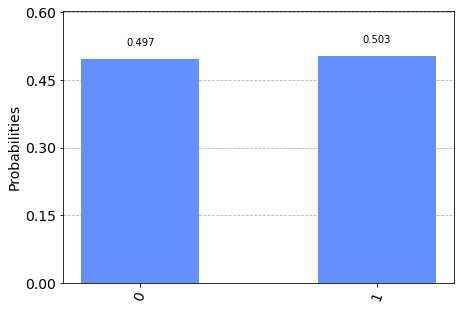

In [4]:
parameterize_and_plot(circuit.copy(), [np.pi/2])

As we can see, it holds up. If we take the state vector of the circuit, we can see why:

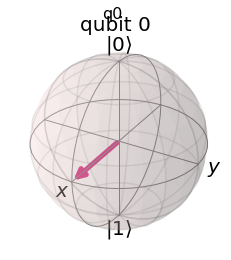

In [5]:
state = Statevector.from_instruction(circuit.copy().bind_parameters([np.pi/2]))
plot_bloch_multivector(state, title="q0", reverse_bits=False)

This means that halving $\pi$ again, so that we get $\frac{pi}{4}$, should return probabilities of ~1/4 and ~3/4:

_For_ $\theta =\ \frac{\pi}{4}$:

$$
\begin{pmatrix}\cos\frac{\pi}{8} \\ \sin\frac{\pi}{8}\end{pmatrix} =\ \begin{pmatrix} 0.9239 \\ 0.3827 \end{pmatrix} =\ \begin{pmatrix} 0.9239 \\ 0 \end{pmatrix} + \begin{pmatrix} 0 \\ 0.3827 \end{pmatrix} =\ 0.9239 * \begin{pmatrix} 1 \\ 0 \end{pmatrix} + 0.3827 * \begin{pmatrix} 0 \\ 1 \end{pmatrix}
$$

To get the _exact_ probabilities, we have to square the values infront of the two state vectors, which results in the following, final form:

$$
\ket{0} \rightarrow 0.9239^2 =\ 0.8536 \\
\ket{1} \rightarrow 0.382t^2 =\ 0.1464 \\
$$


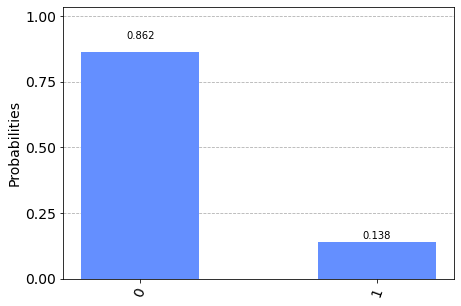

In [6]:
parameterize_and_plot(circuit.copy(), [np.pi/4])

Again, the theory holds. We now want to try to use $\frac{3\pi}{4}$

_For_ $\theta =\ \frac{3\pi}{4}$:

$$
\begin{pmatrix}\cos\frac{3\pi}{8} \\ \sin\frac{3\pi}{8}\end{pmatrix} =\ \begin{pmatrix} 0.3827 \\ 0.9239 \end{pmatrix} =\ \begin{pmatrix} 0.3827 \\ 0 \end{pmatrix} + \begin{pmatrix} 0 \\ 0.9239 \end{pmatrix} =\ 0.3827 * \begin{pmatrix} 1 \\ 0 \end{pmatrix} + 0.9239 * \begin{pmatrix} 0 \\ 1 \end{pmatrix}
$$

To get the _exact_ probabilities, we have to square the values infront of the two state vectors, which results in the following, final form:

$$
\ket{1} \rightarrow 0.9239^2 =\ 0.8536 \\
\ket{0} \rightarrow 0.382t^2 =\ 0.1464 \\
$$

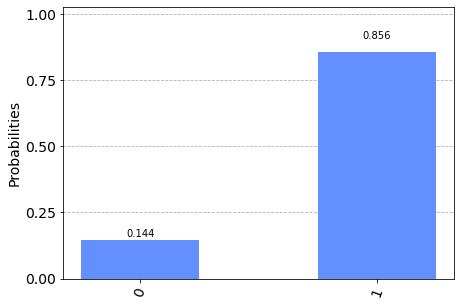

In [7]:
parameterize_and_plot(circuit.copy(), [3*np.pi/4])

As we can see, the probabilities are now inversed. Let's check the bloch sphere:

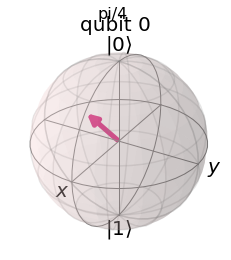

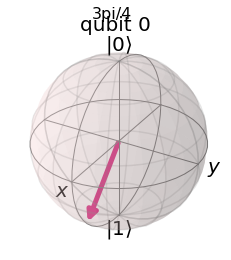

In [8]:
state = Statevector.from_instruction(circuit.copy().bind_parameters([np.pi/4]))
display(plot_bloch_multivector(state, title="pi/4", reverse_bits=False))
state = Statevector.from_instruction(circuit.copy().bind_parameters([3*np.pi/4]))
display(plot_bloch_multivector(state, title="3pi/4", reverse_bits=False))

## Complex circuits

To further allow us to construct mathematical representations of quantum circuits, we need to evaluate more advanced circuits. 

In [9]:
circuit = QuantumCircuit(2)
circuit.ry(Parameter('alpha'), 0)
circuit.cry(Parameter('beta'),0,1)
circuit.draw()

┌───────────┐            
q_0: ┤ Ry(alpha) ├─────■──────
     └───────────┘┌────┴─────┐
q_1: ─────────────┤ Ry(beta) ├
                  └──────────┘

As we can see, this is a circuit that contains 2 qubits, $q_0$ and $q_1$. The initial state of both is $\begin{pmatrix}1 \\ 0\end{pmatrix}$. The first part of the circuit, that is $RY(\alpha)\ket{0}$, remains the same as above and results in the same vector for $q_0$:

$$
q_0 =\ \begin{pmatrix}\cos\frac{\alpha}{2} \\ \sin\frac{\alpha}{2}\end{pmatrix}
$$

As the next gate applies to both our qubits, we have to turn our separate qubit states into one state vector. This can be done by calculating the tensor product of both qubit states:

$$
\begin{pmatrix}\cos\frac{\alpha}{2} \\ \sin\frac{\alpha}{2}\end{pmatrix} \otimes \begin{pmatrix}1 \\ 0\end{pmatrix} =\ 
\begin{pmatrix} \cos\frac{\alpha}{2} \\ 0 \\ \sin\frac{\alpha}{2} \\ 0\end{pmatrix}\\
$$

This means we have an unknown probability for $\ket{00}$ and $\ket{10}$

The _CRY-Gate_ is special in that there are two versions of it. Depending on which "side" the controlling qubit is, we have to take a different one:

$$
CRY(\theta)_{q_0,q_1} =\ 
    \begin{pmatrix}
        1 & 0 & 0 & 0 \\
        0 & \cos{\frac{\theta}{2}} & 0 & -\sin{\frac{\theta}{2}} \\
        0 & 0 & 1 & 0 \\
        0 & \sin{\frac{\theta}{2}} & 0 & \cos{\frac{\theta}{2}}
        \end{pmatrix}
$$

$$
CRY(\theta)_{q_1,q_0} =\ 
    \begin{pmatrix}
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & \cos\frac{\theta}{2} & -\sin\frac{\theta}{2} \\
        0 & 0 & \sin\frac{\theta}{2} & \cos\frac{\theta}{2}
    \end{pmatrix} \\
$$

Where $q_i$ denotes the control qubit and $q_j$ the target qubit in $CRY(\theta)_{q_i,q_j}$

Remember, that because in `qiskit` the endians are switched, we use $CRY(\beta)_{q_0,q_1}$ here.
Lets now multiply our state vector with our $CRY(\beta)_{q_0,q_1}$ matrix:

$$
\begin{pmatrix}
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & \cos\frac{\theta}{2} & -\sin\frac{\theta}{2} \\
        0 & 0 & \sin\frac{\theta}{2} & \cos\frac{\theta}{2}
\end{pmatrix} \begin{pmatrix} \cos\frac{\alpha}{2} \\ 0 \\ \sin\frac{\alpha}{2} \\ 0\end{pmatrix} =\ \begin{pmatrix} \cos\frac{\alpha}{2} \\ 0 \\ \cos\frac{\beta}{2}\sin\frac{\alpha}{2} \\ \sin\frac{\beta}{2}\sin\frac{\alpha}{2}\end{pmatrix}\\
$$

As we can see the state vector does not change. This means, that if we plug in the same values as above, we should get the same results, no matter what $\beta$ is.

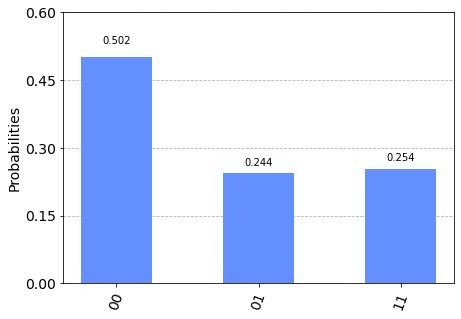

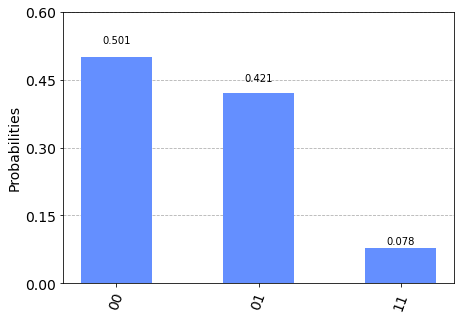

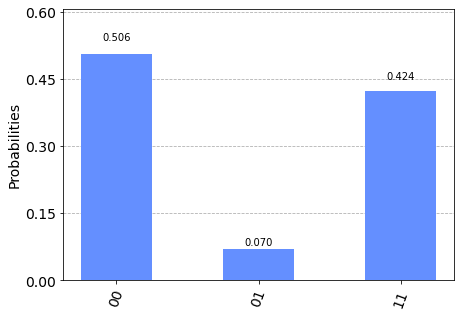

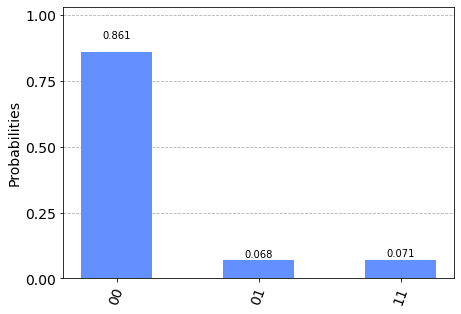

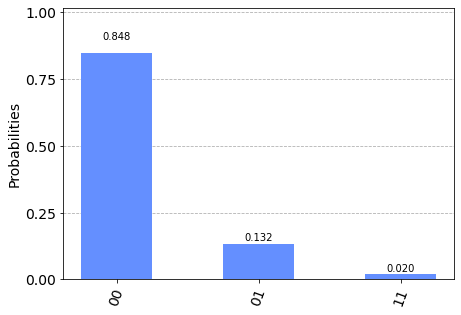

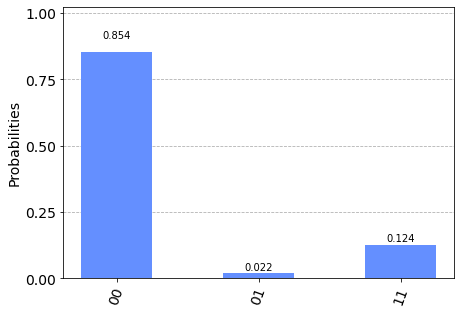

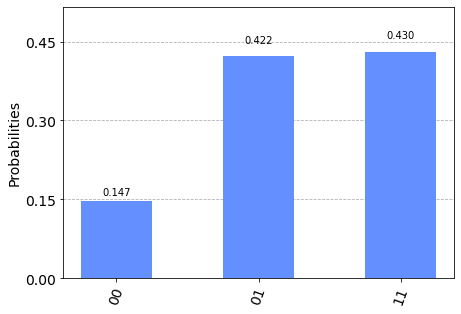

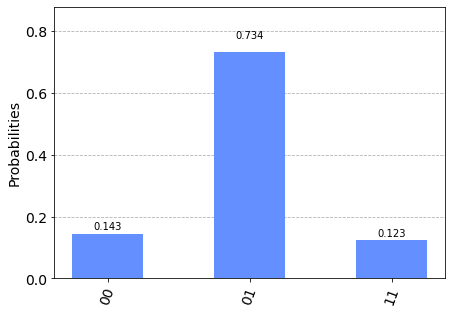

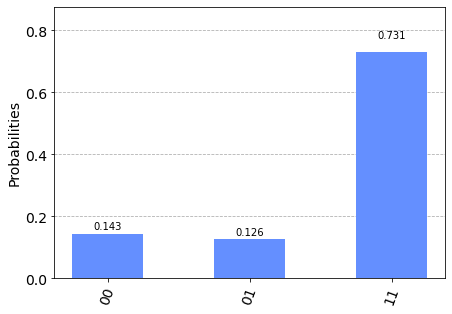

In [10]:
parameterize_and_plot(circuit.copy(),[np.pi/2, np.pi/2])
parameterize_and_plot(circuit.copy(),[np.pi/2, np.pi/4])
parameterize_and_plot(circuit.copy(),[np.pi/2, 3*np.pi/4])

parameterize_and_plot(circuit.copy(),[np.pi/4, np.pi/2])
parameterize_and_plot(circuit.copy(),[np.pi/4, np.pi/4])
parameterize_and_plot(circuit.copy(),[np.pi/4, 3*np.pi/4])

parameterize_and_plot(circuit.copy(),[3*np.pi/4, np.pi/2])
parameterize_and_plot(circuit.copy(),[3*np.pi/4, np.pi/4])
parameterize_and_plot(circuit.copy(),[3*np.pi/4, 3*np.pi/4])

In [11]:
circuit = QuantumCircuit(2)
circuit.ry(Parameter('alpha'),0)
circuit.cry(Parameter('beta'),1,0)
circuit.draw()

┌───────────┐┌──────────┐
q_0: ┤ Ry(alpha) ├┤ Ry(beta) ├
     └───────────┘└────┬─────┘
q_1: ──────────────────■──────

What if we turn the _CRY-Gate_ upside down? The state vector right before it is applied remains the same, but the outcome of the multiplication by $RY(\theta)_{q_1,q_0}$ should differ:

$$
\begin{pmatrix}
    1 & 0 & 0 & 0 \\
    0 & \cos{\frac{\beta}{2}} & 0 & -\sin{\frac{\beta}{2}} \\
    0 & 0 & 1 & 0 \\
    0 & \sin{\frac{\beta}{2}} & 0 & \cos{\frac{\beta}{2}}
\end{pmatrix} \begin{pmatrix} \cos\frac{\alpha}{2} \\ 0 \\ \sin\frac{\alpha}{2} \\ 0\end{pmatrix} =\ \begin{pmatrix} \cos\frac{\alpha}{2} \\ 0 \\ \sin\frac{\alpha}{2} \\ 0\end{pmatrix} \\
$$

And as we can see, it does indeed differ. We now not only have chances of measuring $\ket{00}$ and $\ket{10}$, but surprisingly also $\ket{11}$, even tho we never _directly_ interfered with $q_1$. Lets simulate this and see the outcome:

In [12]:
def print_unitary_matrix(circuit, parameters):
    qc = circuit.bind_parameters(parameters)
    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend)
    result = job.result()
    print(result.get_unitary(qc, decimals=3))

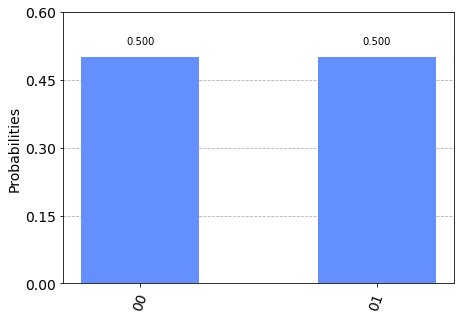

[[ 0.707-0.j -0.707+0.j -0.   +0.j -0.   +0.j]
 [ 0.707-0.j  0.707-0.j  0.   -0.j  0.   -0.j]
 [ 0.   +0.j  0.   +0.j  0.879-0.j  0.477-0.j]
 [ 0.   +0.j  0.   +0.j -0.477+0.j  0.879-0.j]]


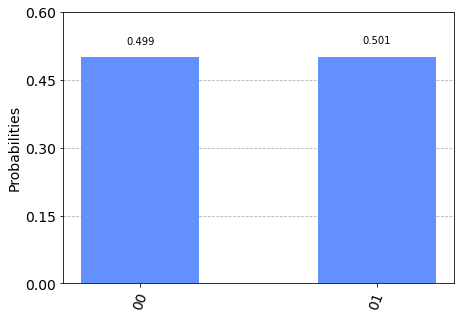

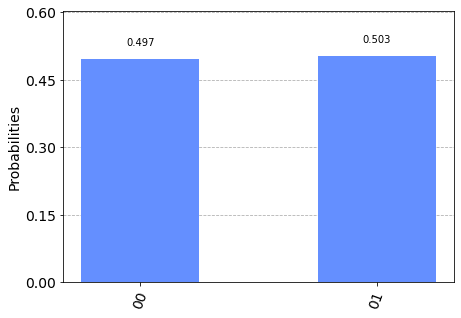

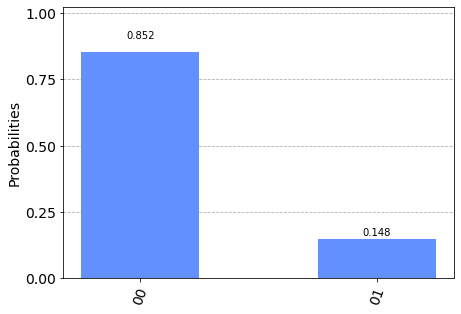

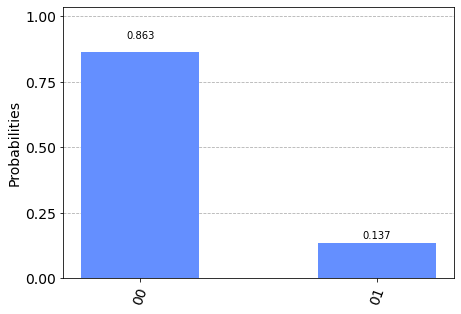

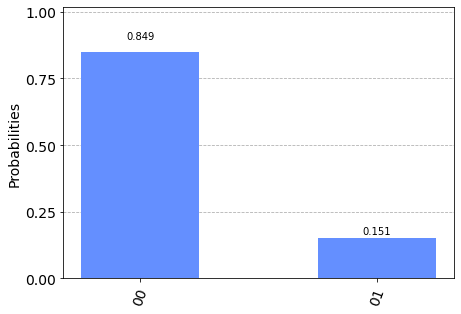

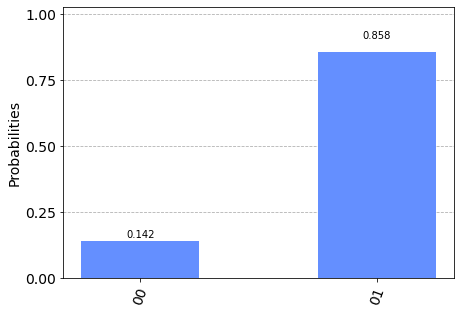

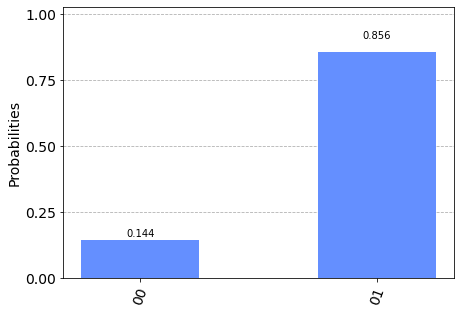

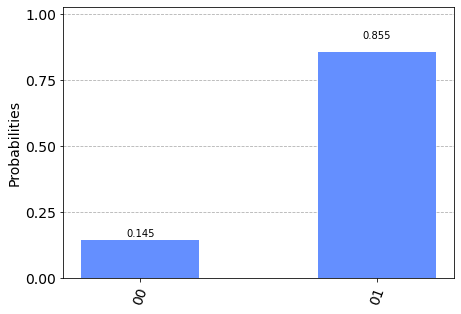

In [13]:
parameterize_and_plot(circuit.copy(),[np.pi/2, 5])
parameterize_and_plot(circuit.copy(),[np.pi/2, 10])
parameterize_and_plot(circuit.copy(),[np.pi/2, 10])

parameterize_and_plot(circuit.copy(),[np.pi/4, np.pi/2])
parameterize_and_plot(circuit.copy(),[np.pi/4, np.pi/4])
parameterize_and_plot(circuit.copy(),[np.pi/4, 3*np.pi/4])

parameterize_and_plot(circuit.copy(),[3*np.pi/4, np.pi/2])
parameterize_and_plot(circuit.copy(),[3*np.pi/4, np.pi/4])
parameterize_and_plot(circuit.copy(),[3*np.pi/4, 3*np.pi/4])